In [20]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms
from torch.autograd import Variable
from tqdm import tqdm
import csv
from torchsummary import summary

data_dir = 'GTSRB/Training'


In [21]:
# Define the transformations.

data_transforms = transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.ToTensor()
    ])


# Define path of training data

train_data_path = data_dir
train_data = datasets.ImageFolder(root = train_data_path, transform = data_transforms)

# Divide data into training and validation (0.8 and 0.2)
ratio = 0.8
n_train_examples = int(len(train_data) * ratio)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = data.random_split(train_data, [n_train_examples, n_val_examples])

In [22]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,5,1)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(32,32,3,1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.conv3 = nn.Conv2d(32,64,1,1)
        nn.init.kaiming_normal_(self.conv3.weight)
        self.conv4 = nn.Conv2d(64,64,3,1)
        nn.init.kaiming_normal_(self.conv4.weight)
        
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4_bn = nn.BatchNorm2d(64)
        
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2_bn = nn.BatchNorm1d(classes)

        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, classes)
        
        self.dropout=nn.Dropout(0.2)

    def forward(self, x):
        
        x = F.relu(self.conv2_bn(self.conv2(F.relu(self.conv1_bn(self.conv1(x))))))
        x = self.pool(x)
        
        x = self.dropout(x)
        
        x = F.relu(self.conv4_bn(self.conv4(F.relu(self.conv3_bn(self.conv3(x))))))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.fc2(x)
    
        return x

In [24]:
def check_accuracy(model, dataloader, model_forward='loss'):
    y_pred = []
    y = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if model_forward!='loss':
        model.eval()
    for batch, (inputs, labels) in tqdm(enumerate(dataloader, 0)):
        inputs = inputs.to(device)
        if model_forward=='loss':
            scores = model.loss(inputs)
        elif model_forward=='forward':
            with torch.no_grad():
                scores = model(torch.tensor(inputs)).detach()
        scores=scores.cpu()
        scores=scores.numpy()
        y.append(labels)
        y_pred.append(np.argmax(scores, axis=1))
        
    y_pred = np.hstack(y_pred)
    y = np.hstack(y)
    acc = np.mean(y_pred == y)

    return acc*100

In [30]:
def training(epochs, batch_size, classes, results, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader = data.DataLoader(train_data, shuffle=True, batch_size = batch_size)
    val_loader = data.DataLoader(val_data, shuffle=True, batch_size = batch_size)

    CNNtest1 = CNN1()
    CNNtest1.to(device)
    criterion = nn.CrossEntropyLoss() # Criterion for the model
    optimizer = optim.Adam(CNNtest1.parameters(), lr) # Initialize the optimizer
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)# Initialize the scheduler
    
    key = lr
    results[key] = np.zeros(epochs)
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader, 0):            
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = CNNtest1(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        running_loss = 0.0
        scheduler.step()
        test_acc = check_accuracy(CNNtest1, val_loader, 'forward')
        results[key][epoch] = test_acc
    return results

In [31]:
results = {}
epochs = 20
classes = 43
batches = [0.1, 0.01, 0.001, 0.0005]
for b in batches:
    training(epochs, 128, classes, results, b)



0it [00:00, ?it/s]/tmp/ipykernel_2668/1098171759.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scores = model(torch.tensor(inputs)).detach()
42it [00:02, 17.73it/s]
42it [00:02, 20.98it/s]
42it [00:02, 17.92it/s]
42it [00:02, 17.71it/s]
42it [00:02, 17.49it/s]
42it [00:01, 21.01it/s]
42it [00:02, 16.87it/s]
42it [00:02, 16.96it/s]
42it [00:02, 18.43it/s]
42it [00:02, 17.13it/s]
42it [00:02, 17.99it/s]
42it [00:02, 17.54it/s]
42it [00:02, 20.68it/s]
42it [00:01, 21.68it/s]
42it [00:02, 17.94it/s]
42it [00:01, 21.48it/s]
42it [00:02, 19.67it/s]
42it [00:02, 19.12it/s]
42it [00:02, 20.49it/s]
42it [00:02, 19.61it/s]
42it [00:01, 21.27it/s]
42it [00:02, 20.35it/s]
42it [00:02, 20.53it/s]
42it [00:02, 19.90it/s]
42it [00:02, 19.80it/s]
42it [00:02, 18.43it/s]
42it [00:01, 21.30it/s]
42it [00:02, 18.89it/s]
42it [00:02, 20.83it/s]
42it

{0.1: array([68.71246246, 88.71996997, 93.24324324, 92.96171171, 93.86261261,
       95.53303303, 94.59459459, 96.753003  , 96.50900901, 96.996997  ,
       96.77177177, 96.77177177, 97.44744745, 96.02102102, 97.2972973 ,
       96.50900901, 97.50375375, 97.44744745, 97.57882883, 96.58408408]), 0.01: array([96.64039039, 98.47972973, 98.23573574, 98.34834835, 98.98648649,
       97.91666667, 99.08033033, 98.78003003, 98.61111111, 99.3993994 ,
       99.3993994 , 99.43693694, 99.43693694, 99.43693694, 99.43693694,
       99.43693694, 99.43693694, 99.43693694, 99.43693694, 99.43693694]), 0.001: array([95.83333333, 98.70495495, 98.87387387, 99.06156156, 99.26801802,
       98.61111111, 99.45570571, 99.49324324, 99.49324324, 99.49324324,
       99.49324324, 99.51201201, 99.49324324, 99.49324324, 99.49324324,
       99.49324324, 99.49324324, 99.49324324, 99.49324324, 99.49324324]), 0.0005: array([86.26126126, 98.02927928, 98.29204204, 98.98648649, 98.85510511,
       99.06156156, 99.02402402

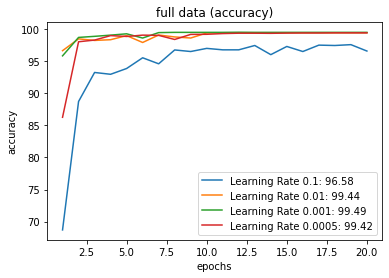

In [32]:
# Graph plotting
ep = [i for i in range(1,epochs+1)]
print(results)
for key, val in results.items():
    plt.plot(ep, val, label=f"Learning Rate {key}: {val[-1]:.2f}")
plt.legend(fontsize=10, title_fontsize=15)
plt.title("full data (accuracy)")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig("plots_with_batchnorm_lrate.png", dpi=500)
plt.show()
